In [140]:
import cv2
import numpy as np
import pandas as pd
import os

# Importing metrics tools
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Importing visualization tools
import seaborn as sn
import matplotlib.pyplot as plt
import pylab as pl

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

# Importing feature extraction tools
from skimage.feature import greycomatrix, greycoprops
import mahotas as mt # Mahotas library for GLCM calculation
from skimage import feature # feature.local_binary_pattern for LBP calculation

import joblib as jb

# BRISK - Feature Point Detector

In [67]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
# from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = jb.load("bovw_segmented_brisk_rf.pkl")

In [68]:
clf, classes_names, stdSlr, k, voc

(RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=30,
                        n_estimators=50, random_state=0),
 ['Aluminium',
  'Battery',
  'Cable and Wire',
  'Cardboard and Paper',
  'Connector',
  'Copper',
  'Iron',
  'Magnetic Tape',
  'Printed Circuit Board',
  'Printer Ribbon and Toner',
  'Tube and Screen',
  'Water Pump'],
 StandardScaler(),
 25,
 array([[161.15197356, 175.04203128,  86.48012474, ...,  55.58922919,
          71.32051759, 100.96620741],
        [178.44390774,  96.55347583,  61.72080667, ..., 140.021656  ,
         113.76729864, 109.21241396],
        [100.42639768,  76.69189614, 114.92573504, ...,  73.05772346,
          91.40676385, 115.87380356],
        ...,
        [119.14279566, 172.60489694, 172.60537516, ..., 103.46353594,
         127.73918034, 107.38338673],
        [162.27713927, 126.91011292, 197.10494354, ..., 171.61550816,
         143.99202008, 112.53480552],
        [209.49876695, 213.21415761, 229.6042484 , ...,  90.

In [69]:
voc.shape

(25, 64)

In [70]:
# Get the path of the testing image(s) and store them in a list
test_path = './waste_images/test_segmented'  

In [71]:
testing_names = os.listdir(test_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [72]:
image_paths[:10]

['./waste_images/test_segmented\\Aluminium\\Aluminium17_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium49_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium55_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium57_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium5_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium63_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium70_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium83_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium85_segmented.JPG',
 './waste_images/test_segmented\\Battery\\Battery100_segmented.JPG']

In [73]:
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [74]:
# Create feature extraction and keypoint detector objects
# SIFT is not available anymore in openCV    

# Create list where all the descriptors will be stored
des_list = []

# BRISK is a good replacement to SIFT. ORB also works but didn't work well for this example
brisk = cv2.BRISK_create(30)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))

In [75]:
des_list[0][1].shape

(1012, 64)

In [76]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

In [77]:
descriptors.shape

(169965, 64)

In [78]:
# Calculate the histogram of features
# vq Assigns codes from a code book to observations.
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [79]:
test_features.shape

(139, 25)

In [80]:
# Scale the features
# Standardize features by removing the mean and scaling to unit variance
# Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

# Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

# Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

true_class =['Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Iron', 'Iron', 'Iron', 

In [81]:
len(predictions)

139

In [82]:
# To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions, labels=classes_names)
#print (cm)
#showconfusionmatrix(cm)

accuracy =  0.39568345323741005


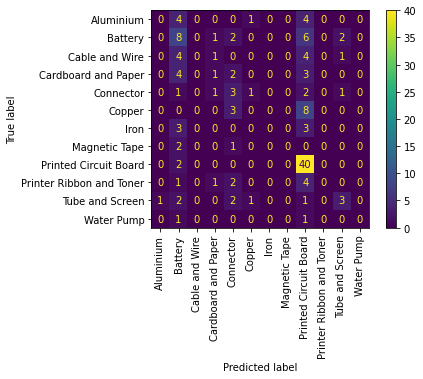

In [83]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(xticks_rotation = 'vertical')
plt.show()

## Accuracy per Class 

In [84]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.        , 0.42105263, 0.        , 0.1       , 0.33333333,
       0.        , 0.        , 0.        , 0.95238095, 0.        ,
       0.3       , 0.        ])

In [85]:
dict_accuracies = {}

for i, class_name in zip(cm_norm.diagonal(), classes_names):
    dict_accuracies[class_name] = round(i,2)


names = list(dict_accuracies.keys())
values = list(dict_accuracies.values())

dict_accuracies

{'Aluminium': 0.0,
 'Battery': 0.42,
 'Cable and Wire': 0.0,
 'Cardboard and Paper': 0.1,
 'Connector': 0.33,
 'Copper': 0.0,
 'Iron': 0.0,
 'Magnetic Tape': 0.0,
 'Printed Circuit Board': 0.95,
 'Printer Ribbon and Toner': 0.0,
 'Tube and Screen': 0.3,
 'Water Pump': 0.0}

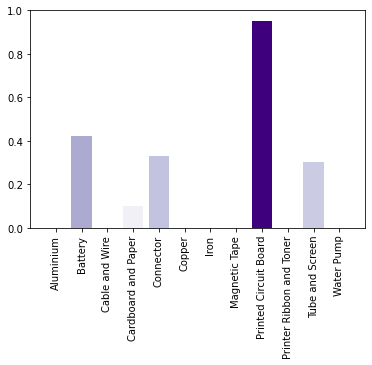

In [86]:
norm = plt.Normalize(0, max(cm_norm.diagonal()))
colors = plt.cm.Purples(norm(cm_norm.diagonal()))

plt.bar(range(len(dict_accuracies)), values, tick_label=names, color=colors)

plt.xticks(rotation = 90)
plt.ylim(top=1)
plt.show()

# GLCM Haralick Features

In [141]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
# from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = jb.load("bovw_segmented_glcm_dt.pkl")

In [142]:
clf, classes_names, stdSlr, k, voc

(DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='auto',
                        min_impurity_decrease=0.0001, min_samples_split=15,
                        random_state=0),
 ['Aluminium',
  'Battery',
  'Cable and Wire',
  'Cardboard and Paper',
  'Connector',
  'Copper',
  'Iron',
  'Magnetic Tape',
  'Printed Circuit Board',
  'Printer Ribbon and Toner',
  'Tube and Screen',
  'Water Pump'],
 StandardScaler(),
 25,
 array([[ 3.17982261e-01,  1.19928066e+02,  9.89667684e-01,
          5.77533243e+03,  6.78442128e-01,  3.92777540e+02,
          2.29814016e+04,  4.57787006e+00,  6.26399530e+00,
          1.57414689e-03,  2.59264299e+00, -4.78781333e-01,
          9.84417151e-01],
        [ 3.52504519e-01,  1.08304601e+02,  9.91252793e-01,
          6.17795315e+03,  6.99951845e-01,  3.94150962e+02,
          2.46035080e+04,  4.35787299e+00,  5.92574355e+00,
          1.70135430e-03,  2.44032171e+00, -4.92689604e-01,
          9.82769769e-01],
        [ 3.11520336e

In [143]:
# Get the path of the testing image(s) and store them in a list
test_path = './waste_images/test_segmented'  

In [144]:
testing_names = os.listdir(test_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [145]:
image_paths[:10]

['./waste_images/test_segmented\\Aluminium\\Aluminium17_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium49_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium55_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium57_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium5_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium63_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium70_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium83_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium85_segmented.JPG',
 './waste_images/test_segmented\\Battery\\Battery100_segmented.JPG']

In [146]:
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [147]:
# Create List where all the descriptors will be stored
des_list = []

In [148]:
def extract_glcm_features(image):
        
    # Calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)

    # Return the mean
    #ht_mean = textures.mean(axis=0)
    #return ht_mean
        
    return textures

In [149]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_glcm_features(gray_img)
    des_list.append((image_path, des)) 

In [150]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

In [151]:
descriptors

array([[  0.25541848,  53.46811424,   0.99400251, ...,   2.55347476,
         -0.49449156,   0.99391223],
       [  0.25134064, 103.11209778,   0.98843892, ...,   3.01946635,
         -0.41484841,   0.9876471 ],
       [  0.25472432,  50.81886091,   0.99430029, ...,   2.50270948,
         -0.50561515,   0.99449909],
       ...,
       [  0.45014546, 116.02675109,   0.98987712, ...,   1.9056002 ,
         -0.55516559,   0.98617585],
       [  0.45427096,  67.6491584 ,   0.99409152, ...,   1.66985712,
         -0.60630148,   0.99004167],
       [  0.45026187, 101.98340962,   0.99110235, ...,   1.89785562,
         -0.55694351,   0.9863352 ]])

In [152]:
# Calculate the histogram of features
# vq Assigns codes from a code book to observations. 
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [153]:
np.unique(test_features)

array([0., 1., 2., 3., 4.], dtype=float32)

In [154]:
# Scale the features
# Standardize features by removing the mean and scaling to unit variance
# Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

# Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]


# Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

true_class =['Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Iron', 'Iron', 'Iron', 

In [156]:
# To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions, labels=classes_names)
#print (cm)
#showconfusionmatrix(cm)

accuracy =  0.3669064748201439


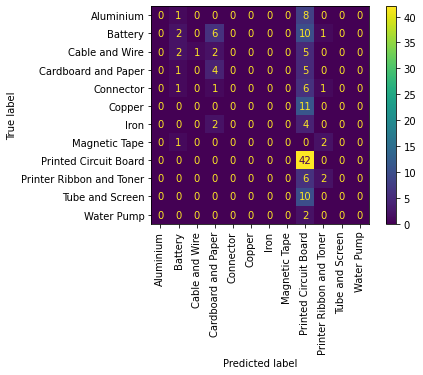

In [157]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(xticks_rotation = 'vertical')
plt.show()

In [158]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.        , 0.10526316, 0.1       , 0.4       , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.25      ,
       0.        , 0.        ])

In [159]:
dict_accuracies = {}

for i, class_name in zip(cm_norm.diagonal(), classes_names):
    dict_accuracies[class_name] = round(i,2)


names = list(dict_accuracies.keys())
values = list(dict_accuracies.values())

dict_accuracies

{'Aluminium': 0.0,
 'Battery': 0.11,
 'Cable and Wire': 0.1,
 'Cardboard and Paper': 0.4,
 'Connector': 0.0,
 'Copper': 0.0,
 'Iron': 0.0,
 'Magnetic Tape': 0.0,
 'Printed Circuit Board': 1.0,
 'Printer Ribbon and Toner': 0.25,
 'Tube and Screen': 0.0,
 'Water Pump': 0.0}

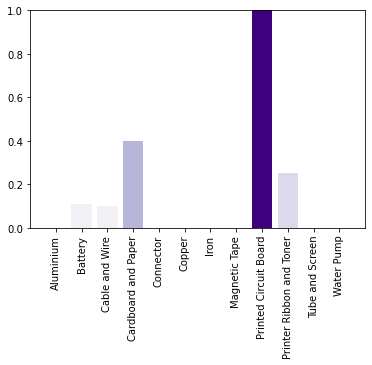

In [160]:
norm = plt.Normalize(0, max(cm_norm.diagonal()))
colors = plt.cm.Purples(norm(cm_norm.diagonal()))

plt.bar(range(len(dict_accuracies)), values, tick_label=names, color=colors)

plt.xticks(rotation = 90)
plt.ylim(top=1)
plt.show()

# LBP - Local Binary Patterns

In [106]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
# from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = jb.load("bovw_segmented_lbp_rf.pkl")

In [107]:
clf, classes_names, stdSlr, k, voc

(RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=30,
                        n_estimators=50, random_state=0),
 ['Aluminium',
  'Battery',
  'Cable and Wire',
  'Cardboard and Paper',
  'Connector',
  'Copper',
  'Iron',
  'Magnetic Tape',
  'Printed Circuit Board',
  'Printer Ribbon and Toner',
  'Tube and Screen',
  'Water Pump'],
 StandardScaler(),
 25,
 array([[4.37569582, 6.76714784, 6.78809322, ..., 6.25125012, 6.29672611,
         4.22756864],
        [4.99178157, 7.97667486, 7.97654422, ..., 7.97264878, 7.97470339,
         5.00100949],
        [4.99590756, 7.9735195 , 7.96569571, ..., 7.91056813, 7.92838228,
         4.98110255],
        ...,
        [4.98197976, 7.96507035, 7.9648235 , ..., 7.93014071, 7.93915083,
         4.98259689],
        [4.99061804, 7.97818694, 7.9746687 , ..., 7.96106485, 7.96153395,
         4.98909347],
        [4.875     , 7.63460243, 7.63005391, ..., 6.46276954, 6.46445418,
         4.293969  ]]))

In [108]:
voc.shape

(22, 640)

In [109]:
# Get the path of the testing image(s) and store them in a list
test_path = './waste_images/test_segmented'

In [110]:
testing_names = os.listdir(test_path)

In [111]:
# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [112]:
image_paths[:10]

['./waste_images/test_segmented\\Aluminium\\Aluminium17_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium49_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium55_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium57_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium5_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium63_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium70_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium83_segmented.JPG',
 './waste_images/test_segmented\\Aluminium\\Aluminium85_segmented.JPG',
 './waste_images/test_segmented\\Battery\\Battery100_segmented.JPG']

In [113]:
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [114]:
# Create list where all the descriptors will be stored
des_list = []

In [115]:
def extract_lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    '''
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist
    '''
    
    return lbp

In [116]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    #gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_lbp_features(im)
    des_list.append((image_path, des)) 

In [117]:
len(des_list)

139

In [118]:
removal_list = []

for image_path, descriptor in des_list[1:]:
    if (descriptor.shape[1] != (640)):
        #print(image_path, descriptor.shape)
        removal_list.append(image_path)

In [119]:
removal_list

['./waste_images/test_segmented\\Cable and Wire\\Cable and Wire106_segmented.JPG',
 './waste_images/test_segmented\\Copper\\Copper28_segmented.JPG',
 './waste_images/test_segmented\\Copper\\Copper5_segmented.JPG',
 './waste_images/test_segmented\\Printed Circuit Board\\Printed Circuit Board130_segmented.JPG',
 './waste_images/test_segmented\\Printer Ribbon and Toner\\Printer Ribbon and Toner38_segmented.JPG']

In [120]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
        if image_path not in removal_list:
            #print(image_path)
            descriptors = np.vstack((descriptors, descriptor))

In [121]:
descriptors

array([[3., 5., 5., ..., 5., 5., 3.],
       [5., 8., 8., ..., 8., 8., 5.],
       [5., 8., 8., ..., 8., 8., 5.],
       ...,
       [5., 8., 8., ..., 8., 8., 5.],
       [5., 8., 8., ..., 8., 8., 5.],
       [3., 5., 5., ..., 5., 5., 3.]])

In [122]:
adjusted_des_list = []

for item in des_list:
    if item[0] not in removal_list:
        #print(item[0])
        adjusted_des_list.append(item)

In [123]:
len(adjusted_des_list)

134

In [124]:
len(removal_list), len(image_paths)

(5, 139)

In [125]:
def list_difference(b, a):
    c = list(b)
    for item in a:
        try:
            c.remove(item)
        except ValueError:
            pass            #or maybe you want to keep a values here
    return c

In [126]:
adjusted_image_paths = list_difference(image_paths, removal_list)
len(adjusted_image_paths)

134

In [127]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

test_features = np.zeros((len(adjusted_image_paths), k), "float32")

for i in range(len(adjusted_image_paths)):
    words, distance = vq(adjusted_des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [128]:
np.unique(test_features)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 124., 125., 126., 127., 129., 130., 131., 132., 133., 134.,
       135., 136., 138., 139., 140., 142., 143., 144., 145., 146., 148.,
       150., 151., 152., 155., 156., 157., 158., 15

In [129]:
labels_classes = {'Aluminium':0, 'Battery':1, 'Cable and Wire':2, 'Cardboard and Paper':3, 'Connector':4,
                'Copper':5, 'Iron':6, 'Magnetic Tape':7, 'Printed Circuit Board':8, 
                'Printer Ribbon and Toner':9, 'Tube and Screen':10, 'Water Pump':11}

list(labels_classes.keys())

['Aluminium',
 'Battery',
 'Cable and Wire',
 'Cardboard and Paper',
 'Connector',
 'Copper',
 'Iron',
 'Magnetic Tape',
 'Printed Circuit Board',
 'Printer Ribbon and Toner',
 'Tube and Screen',
 'Water Pump']

In [130]:
classesToRemove = []

for key in labels_classes:
    for string in removal_list:
        if key in string:
            #print(labels_classes[key])
            classesToRemove.append(labels_classes[key])

In [131]:
classesToRemove

[2, 5, 5, 8, 9]

In [132]:
adjusted_image_classes = list_difference(image_classes, classesToRemove)

In [133]:
len(adjusted_image_classes)

134

In [134]:
# Scale the features
# Standardize features by removing the mean and scaling to unit variance
# Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####

# Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in adjusted_image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]


# Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

true_class =['Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Aluminium', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Battery', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cable and Wire', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Cardboard and Paper', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Connector', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Iron', 'Iron', 'Iron', 'Iron', 'Iron', 'Iron', 'Magnetic Tape

In [135]:
# To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions, labels=classes_names)
#print (cm)
#showconfusionmatrix(cm)

accuracy =  0.3582089552238806


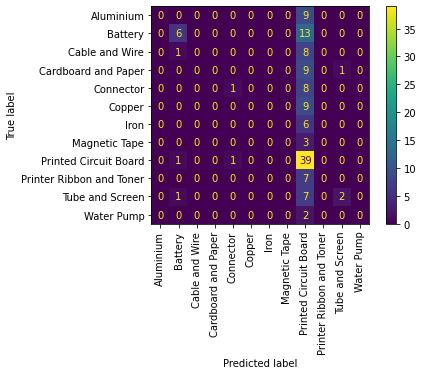

In [136]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(xticks_rotation = 'vertical')
plt.show()

In [137]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.        , 0.31578947, 0.        , 0.        , 0.11111111,
       0.        , 0.        , 0.        , 0.95121951, 0.        ,
       0.2       , 0.        ])

In [138]:
dict_accuracies = {}

for i, class_name in zip(cm_norm.diagonal(), classes_names):
    dict_accuracies[class_name] = round(i,2)


names = list(dict_accuracies.keys())
values = list(dict_accuracies.values())

dict_accuracies

{'Aluminium': 0.0,
 'Battery': 0.32,
 'Cable and Wire': 0.0,
 'Cardboard and Paper': 0.0,
 'Connector': 0.11,
 'Copper': 0.0,
 'Iron': 0.0,
 'Magnetic Tape': 0.0,
 'Printed Circuit Board': 0.95,
 'Printer Ribbon and Toner': 0.0,
 'Tube and Screen': 0.2,
 'Water Pump': 0.0}

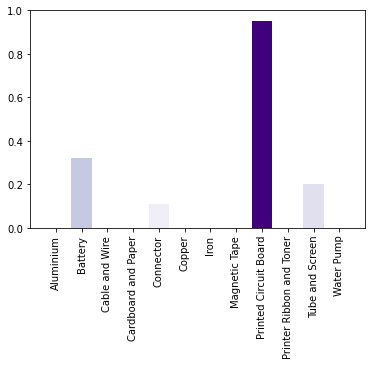

In [139]:
norm = plt.Normalize(0, max(cm_norm.diagonal()))
colors = plt.cm.Purples(norm(cm_norm.diagonal()))

plt.bar(range(len(dict_accuracies)), values, tick_label=names, color=colors)

plt.xticks(rotation = 90)
plt.ylim(top=1)
plt.show()

### Final comments

In this notebook we took eletronic waste images, applied the U2-net to highlight their foreground, applied feature extraction techniques and used their outputs as inputs in several machine learning algorithms to classify images according to their categories (labels). In this multi-class problem, BRISK method created features that produced models capable of predicting the correct category in 40% of the cases in the test data set. The models built with GLCM and LBP features got 37% and 36% of accuracy, respectively.